![Adversarial example](adversarial_example.png "Adversarial example")

In [1]:
import torch
import torch.nn as nn

In [2]:
class ModelTwo(nn.Module):
    def __init__(self):
        super().__init__()
        self.first_conv_layer = nn.Conv2d(1, 16, kernel_size=5)
        self.first_activation = nn.ReLU()
        self.second_layer = nn.LazyLinear(32)
        self.second_activation = nn.ReLU()
        self.third_layer = nn.Linear(32, 16)
        self.third_activation = nn.ReLU()
        self.out_layer = nn.Linear(16, 10)
        self.out_activation = nn.Softmax(dim=1)

    def forward(self, t: torch.Tensor):
        out = self.first_activation(self.first_conv_layer(t))
        dim = 1
        for i in range(1, len(out.shape)):
            dim *= out.shape[i]
        out = out.reshape(len(t), dim)
        out = self.second_activation(self.second_layer(out))
        out = self.third_activation(self.third_layer(out))
        out = self.out_activation(self.out_layer(out))
        return out

In [3]:
model_loaded = torch.load("cnnmodeltwo.model")

In [4]:
from mnist import MNIST
mnist_data = MNIST('samples')
training_images, training_labels = mnist_data.load_training()

original_images = torch.tensor(training_images)
self_training_images = original_images.type(torch.FloatTensor) / 255
self_training_images = torch.reshape(self_training_images, (len(training_images), 28, 28)).unsqueeze(1)
self_training_images.requires_grad = True
self_training_labels = torch.zeros(len(training_labels), 10)
for i in range(len(training_labels)):
    self_training_labels[i, training_labels[i]] = 1
self_training_labels_simple = torch.tensor(training_labels)

In [5]:
if self_training_images.grad is not None:
    self_training_images.grad.zero_()
loss = nn.MSELoss()(model_loaded(self_training_images), self_training_labels)
loss.backward()
grad = self_training_images.grad

In [6]:
self_altered_training_images = self_training_images + 1e-1 * grad.apply_(lambda x: 1 if x >= 0 else -1)

In [7]:
self_altered_training_images = self_altered_training_images.detach()
self_altered_training_images.apply_(lambda x: 1 if x> 1 else (0 if x < 0 else x))  # normalize

tensor([[[[0.1000, 0.1000, 0.0000,  ..., 0.1000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          [0.1000, 0.1000, 0.1000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.0000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.0000, 0.0000,  ..., 0.0000, 0.1000, 0.1000]]],


        [[[0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          ...,
          [0.0000, 0.1000, 0.1000,  ..., 0.1000, 0.1000, 0.1000],
          [0.0000, 0.0000, 0.0000,  ..., 0.1000, 0.1000, 0.1000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.1000, 0.1000]]],


        [[[0.1000, 0.1000, 0.0000,  ..., 0.0000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.0000,  ..., 0.1000, 0.1000, 0.1000],
          [0.1000, 0.1000, 0.0000,  ..

In [8]:
def get_prediction(model, image):
    my_image = image.unsqueeze(0)
    pred = model(my_image)
    maxout = max(pred[0])
    for j in range(10):
        if pred[0, j] == maxout:
            return j, maxout

In [9]:
possible_adversarials = []
for i in range(len(self_training_images)):
    prediction, confidence = get_prediction(model_loaded, self_altered_training_images[i])
    original_prediction, original_confidence = get_prediction(model_loaded, self_training_images[i])
    if prediction != self_training_labels_simple[i]:
        params = {"Label": self_training_labels_simple[i], "Prediction": prediction, "Confidence": confidence,
                  "Index": i, "OriginalPrediction": original_prediction, "OriginalConfidence": original_confidence}
        possible_adversarials.append(params)

In [10]:
len(possible_adversarials)

21546

In [11]:
from matplotlib import pyplot as plt
import numpy as np

In [12]:
def display(image):
    first_image = image[0].reshape((28 * 28,)).detach()
    first_image = np.array(first_image, dtype='float')
    pixels = first_image.reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

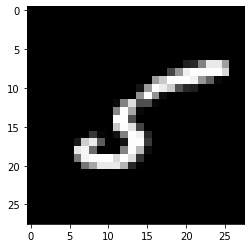

+++++


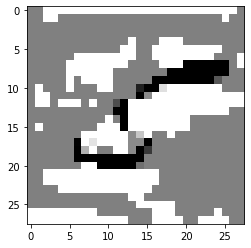

=====


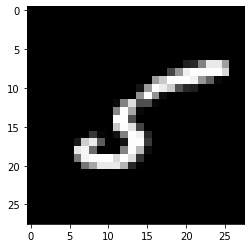

Label: 5, Prediction: 8, Confidence: 0.7538481950759888
Original prediction: 5, Original confidence: 1.0


In [26]:
adversarial = possible_adversarials[2]
original_image = self_training_images[adversarial["Index"]]
altered_image = self_altered_training_images[adversarial["Index"]]
mask = altered_image - original_image
mask = mask #* 255
original_image = original_image #* 255
altered_image = original_image #* 255
display(original_image)
print("+++++")
display(mask)
print("=====")
display(altered_image)
print(f"Label: {adversarial['Label']}, Prediction: {adversarial['Prediction']}, Confidence: {adversarial['Confidence']}")
print(f"Original prediction: {adversarial['OriginalPrediction']}, Original confidence: {adversarial['OriginalConfidence']}")

In [22]:
adversarial = possible_adversarials[2]
original_image = self_training_images[adversarial["Index"]]
altered_image = self_altered_training_images[adversarial["Index"]]
mask = altered_image - original_image
mask = mask * 255
altered_image

tensor([[[0.0000, 0.0000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
          0.1000, 0.1000, 0.1000, 0.0000],
         [0.0000, 0.0000, 0.1000, 0.1000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.1000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,